# Credit Risk Scoring

In [1]:
import pandas as pd
import numpy as np
import wget

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Data cleaning and preparation

In [4]:
link = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
wget.download(link)

100% [................................................................] 182489 / 182489

'CreditScoring.csv'

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [3]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.dtypes

status       int64
seniority    int64
home         int64
time         int64
age          int64
marital      int64
records      int64
job          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
dtype: object

In [5]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [6]:
df.status.value_counts(normalize=True)

1    0.718294
2    0.281481
0    0.000224
Name: status, dtype: float64

In [7]:
# reformat the categorical variables which are int64 into object
# so we could use one-hot encoding later on

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unknown'
}

# we can do this using map() function
df.status = df.status.map(status_values)
df.status.value_counts()

ok         3200
default    1254
unknown       1
Name: status, dtype: int64

In [8]:
# do the same with other features

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unknown'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unknown'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unknown'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unknown'
}

df.job = df.job.map(job_values)

In [9]:
# checking

df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [10]:
# in income, assets and debt we have 99999999 values which stand for NaN
# so we need to replce them

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [11]:
# to_replace=99999999 indicates what we want to replace
# value=np.nan indicates what we want to replace with

for i in ['income', 'assets', 'debt']:
    df[i] = df[i].replace(to_replace=99999999, value=np.nan)

In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [13]:
# let's drop the unknown status

df = df[df.status != 'unknown'].reset_index(drop=True)
df.status.value_counts()

ok         3200
default    1254
Name: status, dtype: int64

# Split the dataset

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# splitting into train and test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# splitting train into train & validation
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [16]:
# checking datasets lenght

len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [17]:
# resetting the index

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
# creating our 'y' values (status) and transforming Series to NumPy array using .values
# we comparing it default status to get 1, so we could predict default

y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

# deleting 'y' (churn) from 'X' dataset

del df_train['status']
del df_val['status']
del df_test['status']

In [19]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,14,owner,60,30,married,no,fixed,60,70.0,4000.0,2800.0,600,1125
1,2,parents,60,35,married,no,fixed,75,104.0,0.0,0.0,1200,1677
2,8,rent,36,61,single,no,fixed,42,72.0,0.0,0.0,325,450
3,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
4,2,other,60,41,separated,no,freelance,35,100.0,5000.0,0.0,1200,1450


In [20]:
y_train

array([0, 0, 0, ..., 0, 0, 1])

# Decision trees

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [22]:
# perform one-hot encoding for training dataset

train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [23]:
# train the training dataset

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [24]:
# perform one-hot encoding for validation dataset

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
# making a prediction and checking AUC on validation datset

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6522600712386495

In [26]:
# making a prediction and checking AUC on training datset

y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

# we've got ~ 1, which indicates overfitting

0.9999996473061242

In [27]:
# we may generalize model by limiting max depth of the tree

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [28]:
# re-training the model and checking AUC

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7175133670978937
val: 0.7128913108914865


In [31]:
# visualization of the tree

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- seniority <= 2.50
|   |--- records=yes <= 0.50
|   |   |--- class: 0
|   |--- records=yes >  0.50
|   |   |--- class: 1
|--- seniority >  2.50
|   |--- records=no <= 0.50
|   |   |--- class: 0
|   |--- records=no >  0.50
|   |   |--- class: 0



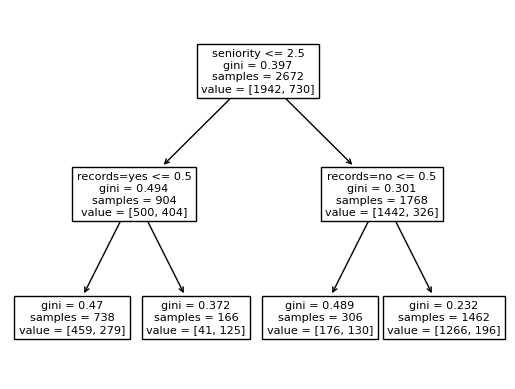

In [50]:
# another way of visualing of the tree

from sklearn.tree import plot_tree

plt.figure()
plot_tree(dt, max_depth=2, feature_names=dv.get_feature_names_out().tolist());